# Training AlexNet with tips and checks on how to train CNNs: Practical CNNs in PyTorch(1)

In [ ]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Step 1 Create Data Pipeline

My Data dirs explained. For my train dataset I use the validation dataset provided by Imagenet i.e. 50000 images. All these images are stored under the train folder. One preprocessing step that I done is to rescale all these images, so that their shorter side is 256. To do this you can either add a transform.Resize(256) or from the terminal run this command and all their images would be rescaled to 256 and stored on disk
```(python)
    find . -name "*.JPEG" | xargs -I {} convert {} -resize "256^>" {}
```

For my validation data, I use 10 images from each class from the train dataset of Imagenet. Below I give the script I used to do so. These images are also rescaled to 256 on the shorter side using the above command. 

In [ ]:
# Run this cell to get 10 images from train folder and place them in your val folder
import os
import shutil

source_dir = '../../../Data/ILSVRC/Data/CLS-LOC/train/'
dest_dir = '../../../Data/ILSVRC2012/val/'
dirs = os.listdir(source_dir)
dirs.sort()

for dir in dirs:
    os.makedirs(dest_dir + dir)
    path_source = source_dir + dir
    path_dest = dest_dir + dir
    images = os.listdir(path_source)
    
    for i in range(10):
        shutil.copy(path_source + '/' + images[i], path_dest)

### 1.1 Create the dataloaders

For the transforms we first need to crop our images, as the input size for our model is 224. For the training dataset I use RandomHorizontalFlip as a data augmentation technique. Another technique that is useful is the FiveCrop transform. But I did not use that here. The images are normalized using the standard values of mean and std computed over the entire ImageNet.

For the validation I did not use data augmentation.

In [ ]:
train_dir = '../../../Data/ILSVRC2012/train'
val_dir = '../../../Data/ILSVRC2012/val'

size = 224
batch_size = 32
num_workers = 8

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

image_datasets = {
    'train': ImageFolder(train_dir, transform=data_transforms['train']),
    'val': ImageFolder(val_dir, transform=data_transforms['val']),
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=num_workers) for x in ['train', 'val']
}

### 1.2 Plot some images to test everything is working

In [ ]:
# For imagenet we need to do some preprocessing for the labels
f = open("../../../Data/LOC_synset_mapping.txt", "r")
labels_dict = {}
labels_list = []
for line in f:
    split = line.split(' ', maxsplit=1)
    split[1] = split[1][:-1]
    label_id, label = split[0], split[1]
    labels_dict[label_id] = label
    labels_list.append(split[1])
   
print('Labels dict:-')
for idx, (key, value) in enumerate(labels_dict.items()):
    print(key, value)
    if (idx > 3):
        break
        
print('\nLabels list (just 0 indexed instead of file names)')
labels_list[:4]

Labels dict:-
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark

Labels list (just 0 indexed instead of file names)


['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

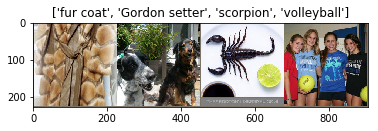

In [ ]:
# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(data_loader['train']))
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[:4]])

## Step 2 Model Construction

1. Activation function:- ReLU is the default choice. But LeakyReLU is also good. Use LeakyReLU in GANs always.
2. Weight Initialization:- Use He initialization as default with ReLU. 
3. Preprocess data:- There are two choices normalizing between [-1,1] or using (x-mean)/std approch. Your choice for this.
4. Batch Normalization:- Apply before non-linearity i.e. ReLU. For the values of the mean and variance use the running average of the values while training as test time. PyTorch automatically maintains this for you. Note: In a recent review paper for ICLR 2019, FixUp initialization was introduced. Using it, you don't need batchnorm layers in your model.
5. Pooling layers:- Apply after non-linearity i.e. ReLU. Different tasks would require different pooling methods for classification max-pool is default.
6. Optimizer:- Adam is a good choice, SDG+momentum+nesterov is also good. fast.ai recently announced a new opitimizer AdamW. Choice of optiimzer comes to experimentation and the task at hand. Look for some benchmarks for different optimizers that can guide your choice.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x
    
model = AlexNet()
model

AlexNet(
  (conv_base): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_base): Sequential(
 

### 2.1 Weight Initialization

In [ ]:
# Here we use indexing to index the layers, but in future cases we would name the layers
conv_list = [0, 4, 8, 10, 12]
fc_list = [1, 4, 6]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model.fc_base[i].weight)

### 2.2 Create opimizer, learning_rate scheduler, loss function

In [ ]:
# We train everything on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

model = model.to(device)

cuda


## Create the train loop

In [ ]:
# A simple train loop that you can use. You can seperate different train and val functions also.
def train(model, data_loader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            for idx, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if idx%200 == 0:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} step in progress'.format(epoch+1, idx, len(data_loader)))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

## Checks to do

### 1. Try to overfit a small mini-batch
We do this step to check the capacity of our model. If our model is not able to overfit a small mini-batch it would not be able to generalize over the dataset. So if your model is not able to overfit, you should try checking the loss and criterion to see if you have made a mistake or not. If your model is still not able to overfit, then you have to change your model, by increasing the capacity the model.

__Note__ :- Remember to reinitialize your weights after this step. Turn off regularization and use vanilla SGD. Here you should also avoid Dropout and other regularizations. But you can move without the previous step also.

In [ ]:
inputs, labels = next(iter(data_loader['train']))
inputs = inputs.to(device)
labels = labels.to(device)

criterion_check1 = nn.CrossEntropyLoss()
optimizer_check1 = optim.SGD(model.parameters(), lr=0.001)

model.train()
for epoch in range(200):
    optimizer_check1.zero_grad()
    outputs = model(inputs)
    loss = criterion_check1(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check1.step()
    
    if epoch%10 == 0:
        print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 10.85702133178711 Accuracy = 0
Epoch 11: Loss = 6.088886737823486 Accuracy = 0
Epoch 21: Loss = 5.023783206939697 Accuracy = 2
Epoch 31: Loss = 3.3892719745635986 Accuracy = 13
Epoch 41: Loss = 3.0263545513153076 Accuracy = 11
Epoch 51: Loss = 2.010768413543701 Accuracy = 19
Epoch 61: Loss = 1.818111777305603 Accuracy = 20
Epoch 71: Loss = 1.7510178089141846 Accuracy = 21
Epoch 81: Loss = 1.2449636459350586 Accuracy = 23
Epoch 91: Loss = 0.8979728817939758 Accuracy = 29
Epoch 101: Loss = 1.0456411838531494 Accuracy = 26
Epoch 111: Loss = 0.692730188369751 Accuracy = 30
Epoch 121: Loss = 0.5408506393432617 Accuracy = 30
Epoch 131: Loss = 0.4986892342567444 Accuracy = 30
Epoch 141: Loss = 0.5481717586517334 Accuracy = 29
Epoch 151: Loss = 0.47915372252464294 Accuracy = 30
Epoch 161: Loss = 0.37656792998313904 Accuracy = 31
Epoch 171: Loss = 0.354257732629776 Accuracy = 30
Epoch 181: Loss = 0.4068177342414856 Accuracy = 31
Epoch 191: Loss = 0.2683148980140686 Accuracy = 32

The model clearly overfitted out mini-batch of 32 training examples. So now we know our model is atleast capable of modeling this type of data. 

In [ ]:
# Reinitialize weights
conv_list = [0, 4, 8, 10, 12]
fc_list = [1, 4, 6]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model.fc_base[i].weight)

### 2. Double check loss
In this step you check the loss values directly. This can give an intutition as to whether your model is correct or not. For example suppose we are doing binary classification, so on the first stpe seeing a loss of 2.3 is good but if you see a loss value of 100 then you can clearly see that there is something wrong. If you are seeing some large loss values you should double check your weight values or some connections in between which may be making your loss large.

For our case, you can see the loss was 10.85 in the first step. Which is very good seeing that we have 1000 classes.

__Note__ :- Do this step with regularization off then again do this step with regularization on. When there is regularization you would see a large loss value, due to the regularized terms.

In [ ]:
# Carrying over the above case with regularization on
criterion_check1 = nn.CrossEntropyLoss()
optimizer_check1 = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.05)

model.train()
for epoch in range(1):
    optimizer_check1.zero_grad()
    outputs = model(inputs)
    loss = criterion_check1(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check1.step()
    print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 11.014405250549316 Accuracy = 0


The loss is still ok as for 1000 classes with regularization it is still around 11. In case you are wondering that the loss values are still close to each other, remember that BatchNormalization and Dropout are also a form of regularization and we did not remove them in Check 1.

So now we do a simple test by removing these layers from the model and comparing the results.

In [ ]:
class AlexNet_check(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet_check, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
#             nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
#             nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
#             nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x
    
model_check2 = AlexNet_check()
model_check2 = model_check2.to(device)

# Initialize weights
conv_list = [0, 3, 6, 8, 10]
fc_list = [0, 2, 4]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model_check2.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model_check2.fc_base[i].weight)
    
criterion_check = nn.CrossEntropyLoss()
optimizer_check = optim.Adam(model_check2.parameters(), lr=0.001)

In [ ]:
model_check2.train()
for epoch in range(1):
    optimizer_check.zero_grad()
    outputs = model(inputs)
    loss = criterion_check(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check.step()
    print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 9.063738822937012 Accuracy = 0


We can see a small difference but this difference is not much significant due to random noise. But as the model size increases regularization becomes even more important and this difference becomes more significant

## Hyperparameter optimization

An important step which can significantly imporve the accuracy of your model. There are 3 main methods to do hyperparameter optimization Grid Search, Random Search and Population based Training (PBT). PBT was released by Deepmind and it uses multiple GPUs to do the optimization. I have a single GPU, so we focus more on the other two options. Always prefer Random Search over Grid Search as you can get better results, by using less resources. There are bayesian methods also available. You can find libraries dedicated to hyperparameter optimization in PyTorch

When it comes to hyperparameter optimization you have to first do course and then fine optimization. By course and fine I am referring to the depth of the optimization. Suppose you want to tune your weight_decay. You choose some values, now rather than training long hours and seeing which values is best, you train only a few epochs with different weight decay values and see which is performing good. (You can do this by manually seeing the loss function). After selecting the better performing values, you now do a finer search where you train your model for more epochs and choose which value gives the best value. 

__Note__ :- If cost > 3*original_cost at any point break out early

## Transfer learning

To do transfer learning you have two options:-
1. Finetuning -> Start with a pretrained model and learn all the weights again
2. Feature extraction -> Start with a pretrained model and learn only the last FC layers.

The conv_base in your model essentially learns to detect edges in the starting layers and then learns complex structures as the depth increases. In general these features are same across different datasets, so you don't have to always retrain this part. But in case you have to, use a small learning rate for the starting layers as detecting edges is same across different datasets and you don't want to loose your prior knowledge. 

The last FC layers are more concerned with optimizing the output according to our requirements. These layers are more dataset dependent and these layers must be learnt again, specific to your dataset. You should remove the last layer. In case of Imagenet models, the last layer is 1000 fully connected layer and you should remove this layer and create a new FC layer with the number of classes equal to number of classes in your dataset.

In [ ]:
data = np.load('../../../Data/cifar_10.npz')
alexnet = torch.load('../../../Data/Pytorch Trained Models/alexnet.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.from_numpy(data['train_data'])
y_train = torch.from_numpy(data['train_labels'])
x_test = torch.from_numpy(data['test_data'])
y_test = torch.from_numpy(data['test_labels'])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([50000, 32, 32, 3])
torch.Size([50000])
torch.Size([10000, 32, 32, 3])
torch.Size([10000])


In [ ]:
# Create data loader
class CIFAR_Dataset(torch.utils.data.Dataset):
    """
    Generally you would not load images in the __init__ as it forces the images
    to load into memory. Instead you should load the images in getitem function,
    but as CIFAR is small dataset I load all the images in memory.
    """
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        image =  self.x[idx]
        label = self.y[idx].item()
        
        if self.transform:
            image = self.transform(image)
        return (image, label)
            
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

datasets = {
    'train': CIFAR_Dataset(x_train, y_train, transform=data_transforms),
    'test': CIFAR_Dataset(x_test, y_test, transform=data_transforms)
}

data_loader = {
    x: torch.utils.data.DataLoader(datasets[x],
                                   batch_size=64,
                                   shuffle=True,
                                   num_workers=8) for x in ['train', 'test']
}

In [ ]:
# Freeze conv layers
for param in alexnet.parameters():
    param.requires_grad = False
    
# Initialize the last layer of alexnet model for out 10 class dataset
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Create list of params to learn
params_to_learn = []
for name,param in alexnet.named_parameters():
    if param.requires_grad == True:
        params_to_learn.append(param)
        
optimizer = optim.SGD(params_to_learn, lr=0.001, momentum=0.9, nesterov=True)

In [ ]:
# Train the model
for epoch in range(20):
    # Train phase
    alexnet.train()
    for idx, (inputs, labels) in enumerate(data_loader['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = alexnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    # Val phase
    alexnet.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in data_loader['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            output = alexnet(inputs)
            loss = criterion(output, labels)
            
            _, preds = torch.max(output, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / len(data_loader['test'].dataset)
    epoch_acc = running_corrects.double() / len(data_loader['test'].dataset)
    
    print('{}. Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

0. Loss: 2.2627 Acc: 0.2076
1. Loss: 2.1685 Acc: 0.2054
2. Loss: 2.0822 Acc: 0.2573
3. Loss: 2.1001 Acc: 0.2472
4. Loss: 2.1214 Acc: 0.2412
5. Loss: 2.1106 Acc: 0.2499
6. Loss: 2.0988 Acc: 0.2429
7. Loss: 2.0620 Acc: 0.2702
8. Loss: 2.1272 Acc: 0.2409
9. Loss: 2.0644 Acc: 0.2502


KeyboardInterrupt: 